In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import waterfall_chart
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from collections import defaultdict

In [3]:
df = pd.read_stata("HCMST 2017 fresh sample for public sharing draft v1.1.dta")

### Wybór zmiennych

In [4]:
df['y'] = 1 - df['S1'].cat.codes

1. Zmienne jakościowe  
a) `Q25` - Did you and [Partner name] attend the same high school?  
b) `ppmarit` -  Marital Status  

2. Zmienne ilościowe  
a) `ppincimp` - Household Income  
b) `Q16` - How many of your relatives do you see in person at least once a month?
 Include parents, brothers and sisters, uncles, aunts, cousins,
 grandparents, or others.   

In [5]:
columns = ['Q25', 'ppmarit', 'ppincimp', 'Q16', 'y']

In [6]:
df = df[columns].dropna()

In [7]:
X = df[columns[:4]].copy()
X.loc[:, columns[:3]] = X[columns[:3]].apply(lambda x: x.cat.codes, axis=0)
y = df['y']

### Model

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
gbm = xgb.XGBClassifier(learning_rate =0.1, n_estimators=50, max_depth=8, objective='binary:logistic', seed=27)
rf = RandomForestClassifier(n_estimators=100)
svc = SVC(gamma='scale', probability=True, random_state=123)
models = dict(zip(["XGBoost", "RandomForest", "SupportVectorMachine"], [gbm, rf, svc]))

In [10]:
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5)
    print(f"[{name}] Cross validation score: {scores.mean()}")

[XGBoost] Cross validation score: 0.9471153470576985
[RandomForest] Cross validation score: 0.938652832670235
[SupportVectorMachine] Cross validation score: 0.9407667551353578


In [11]:
for key in models.keys():
    models[key] = models[key].fit(X, y)

## Feature importance

In [12]:
def permutation_loss_decrease(model, X, y):
    accuracy_results = defaultdict(list)
    base_accuracy = accuracy_score(y, model.predict(X))
    for i in range(100):
        for column in X.columns:
            X_trasformed = X.copy()
            X_trasformed[column] = np.random.permutation(X_trasformed[column].values)
            accuracy = accuracy_score(y, model.predict(X_trasformed))
            accuracy_results[column].append(base_accuracy - accuracy)
    return dict([(key, np.mean(values)) for key, values in accuracy_results.items()])

In [13]:
results = defaultdict(list)
for name, model in models.items():
    scores = permutation_loss_decrease(model, X, y)
    print(f"[{name}] Feature importance: {scores}")
    results[name].append(scores)

[XGBoost] Feature importance: {'Q25': 0.0015867418899858632, 'ppmarit': 0.36467207334273616, 'ppincimp': 0.010098730606487964, 'Q16': 0.008053596614950599}
[RandomForest] Feature importance: {'Q25': 0.009629760225669914, 'ppmarit': 0.3712552891396333, 'ppincimp': 0.028938645980253867, 'Q16': 0.028444992947813805}
[SupportVectorMachine] Feature importance: {'Q25': 0.0, 'ppmarit': 0.34363540197461206, 'ppincimp': 0.0003561354019745866, 'Q16': 0.00035613540197458436}


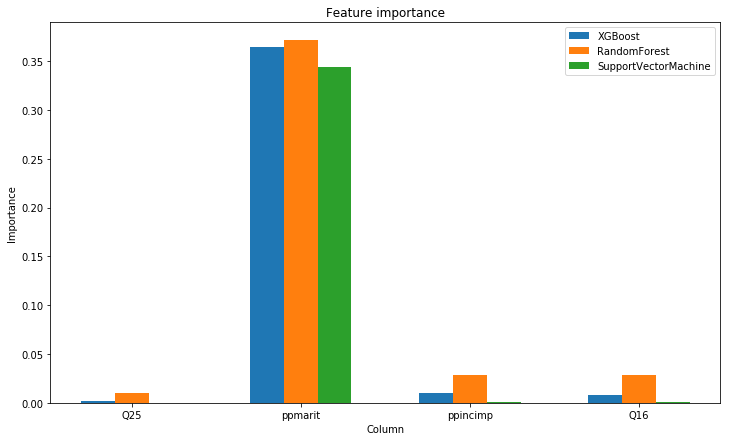

In [18]:
index = np.arange(4)
bar_width = 0.2

fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(12)

for idx, (key, column_values) in enumerate(results.items()):
    ax_bar = ax.bar(index+idx*bar_width, column_values[0].values(), bar_width, label=key)

ax.set_xlabel('Column')
ax.set_ylabel('Importance')
ax.set_title('Feature importance')
ax.set_xticks(index + 1 * bar_width)
ax.set_xticklabels(X.columns)
ax.legend()

plt.show()

Najbardziej różniącującą zmienną jest `ppincimp` (Household Income). W przypadku lasu losowego zmiana tej wartości powoduje duże pogorszenie wyników. XGBoost (najlepszy z predyktorów) notuje delikatnie gorsze wyniki a SVM wydaje się zupełnie nie korzystać z tej cechy.

## ALE plot (ppincimp)

In [19]:
def ale_plot(model, model_name, X, y, splits, variable):
    diffs = [0]
    for i in range(1, len(splits)):
        X[variable] = X[variable].astype('float')
        points = X[(X[variable] >= splits[i - 1]) & (X[variable] <= splits[i])]
        forward_points = points.copy()
        forward_points[variable] = splits[i]
        backward_points = points.copy()
        backward_points[variable] = splits[i - 1]
        difference = np.mean(model.predict_proba(forward_points)[::, 1] - model.predict_proba(backward_points)[::, 1])
        diffs.append(difference)
    ale_values = np.cumsum(diffs)
    plt.plot(splits, ale_values, label=model_name)

In [20]:
splits = sorted(X["ppincimp"].unique())

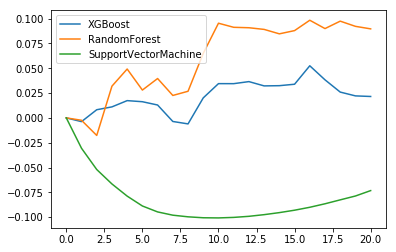

In [21]:
for name, model in models.items():
    ale_plot(model, name, X, y, splits, "ppincimp")
plt.legend([name for name, model in models.items()])

Wyniki są dość zaskakujące ze względu na przeciwne kierunki średniego wpływu przywidywania dla modeli XGBoost i lasu losowego do przewidywań support vector machine.  


Dodatkowo zmiana przewidywań dla SVM wydaje się dosyć istotna podczas analizy wykresu ALE, a zupełnie inne wnioski daje analiza ważności zmiennej za pomocą techniki spadeku funkcji loss po perturbacjach.  

Może to być związane z generowaniem nienaturalnych przypadków w przypadku pierwszej metody. Nienaturalne rekordy mogą powstawać ze względu na wysoką korelację między zmiennymi `ppmarit` i `ppincimp`

In [23]:
X.corr()

,Q25,ppmarit,ppincimp,Q16
Q25,1.000000,0.020233,0.055684,-0.092281
ppmarit,0.020233,1.000000,-0.273098,0.033319
ppincimp,0.055684,-0.273098,1.000000,-0.070839
Q16,-0.092281,0.033319,-0.070839,1.000000
